In [ ]:
!pip install wandb
!pip install swig
!pip install gym[all]
!pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt

Episode 1, Total Reward: -162.72757433894577 Total Steps:97
Episode 2, Total Reward: -386.8244617869609 Total Steps:107
Episode 3, Total Reward: -282.2884240594841 Total Steps:124
Episode 4, Total Reward: -221.1499931280496 Total Steps:74
Episode 5, Total Reward: -53.467941647155556 Total Steps:88
Episode 6, Total Reward: -57.601917405345205 Total Steps:80
Episode 7, Total Reward: -282.695711214478 Total Steps:125
Episode 8, Total Reward: -77.72296848166089 Total Steps:101
Episode 9, Total Reward: -304.19966484819236 Total Steps:128
Episode 10, Total Reward: -103.06458692845965 Total Steps:83
Episode 11, Total Reward: -250.45611591347068 Total Steps:191
Episode 12, Total Reward: -139.79158903591835 Total Steps:140
Episode 13, Total Reward: -230.3864674647788 Total Steps:205
Episode 14, Total Reward: -123.79491517913327 Total Steps:325
Episode 15, Total Reward: -171.2049747949976 Total Steps:123
Episode 16, Total Reward: -357.6563195912898 Total Steps:131
Episode 17, Total Reward: -219.

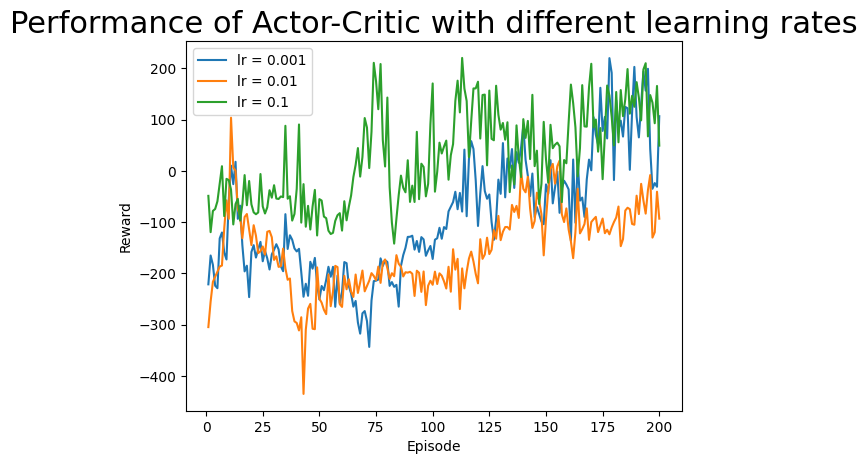

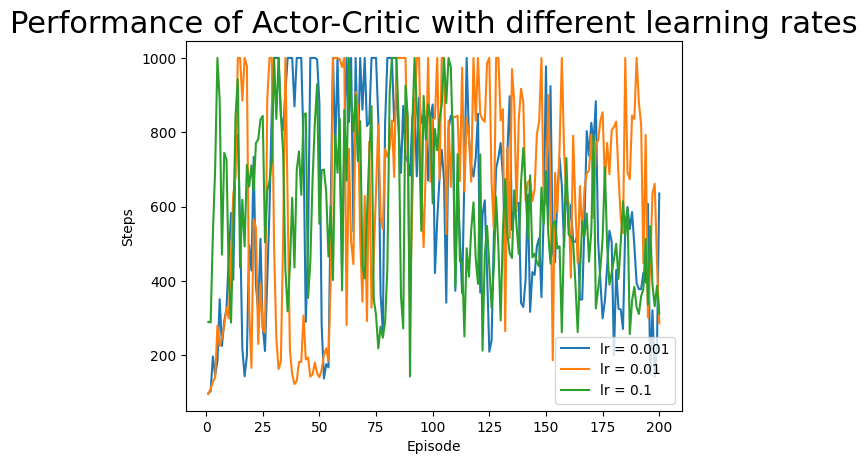

In [8]:


# Actor Network
class Actor(nn.Module):
    def __init__(self, input_size=8, output_size=4, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.fc2(x)
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, input_size=8, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.fc2(x)
        return x

# Actor-Critic Model
class ActorCritic(nn.Module):
    def __init__(self, actor, critic, lr):
        super(ActorCritic, self).__init__()
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

    def forward(self, state):
        action_probs = torch.softmax(self.actor(state), dim=-1)
        state_value = self.critic(state)
        return action_probs, state_value



# Training loop
def update(agent, states, actions, rewards, next_states, dones, gamma=0.99):
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
    rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

    # Compute TD targets
    with torch.no_grad():
        _, next_state_values = agent(next_states)
        td_targets = rewards + gamma * (1 - dones) * next_state_values

    # Compute advantages
    _, state_values = agent(states)
    advantages = td_targets - state_values

    # Actor loss
    action_probs, _ = agent(states)
    log_probs = torch.log(action_probs.gather(1, actions))
    actor_loss = -(log_probs * advantages.detach()).mean()

    # Critic loss
    critic_loss = nn.MSELoss()(state_values, td_targets)

    # Update actor and critic networks
    agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    agent.actor_optimizer.step()

    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    agent.critic_optimizer.step()

def smoothing(array):
  averages = []
  for i in range(0, len(array), 5):
      chunk = array[i:i+5]
      avg = sum(chunk) / len(chunk)
      averages.append(avg)
  return averages

def run(agent, env, n_episodes):
  epi_reward = []
  steps = []
  for i_episode in range(n_episodes):
    total_steps = 0
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        total_steps += 1
        action_probs, _ = agent(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        action = torch.multinomial(action_probs, num_samples=1).item()
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        update(agent, [state], [action], [reward], [next_state], [done])
        state = next_state

    print(f"Episode {i_episode + 1}, Total Reward: {total_reward} Total Steps:{total_steps}")
    steps.append(total_steps)
    epi_reward.append(total_reward)
  env.close()
  return epi_reward, steps

def compute_averages(array):
  averages = []
  for i in range(0, len(array), 5):
    temp = array[i:i+5]
    avg = sum(temp) / len(temp)
    averages.append(avg)
  return averages

def main():
  # Create Lunar Lander environment
  env = gym.make('LunarLander-v2')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  n_episodes = 1000

  # Create actor, critic, and agent
  actor1 = Actor(state_size, action_size)
  critic1 = Critic(state_size)
  agent1 = ActorCritic(actor1, critic1, 0.001)
  e_array = [i for i in range(1, 201)]

  r_array1, s_array1 = run(agent1, env, n_episodes)



  r1 = smoothing(r_array1)
  s1 = smoothing(s_array1)

  # Define optimizer for actor and critic

  actor2 = Actor()
  critic2 = Critic()
  agent2 = ActorCritic(actor2, critic2, 0.01)

  r_array2, s_array2 = run(agent2, env, n_episodes)

  r2 = smoothing(r_array2)
  s2 = smoothing(s_array2)



  actor3 = Actor()
  critic3 = Critic()
  agent3 = ActorCritic(actor3, critic3, 0.1)

  r_array3, s_array3 = run(agent2, env, n_episodes)

  r3 = compute_averages(r_array3)
  s3 = compute_averages(s_array3)


  plt.title("Performance of Actor-Critic with different learning rates",fontsize=22)
  plt.plot(e_array, r1, label = "lr = 0.001")
  plt.plot(e_array, r2, label = "lr = 0.01")
  plt.plot(e_array, r3, label = "lr = 0.1")
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.legend()
  plt.show()

  plt.title("Performance of Actor-Critic with different learning rates",fontsize=22)
  plt.plot(e_array, s1, label = "lr = 0.001")
  plt.plot(e_array, s2, label = "lr = 0.01")
  plt.plot(e_array, s3, label = "lr = 0.1")
  plt.xlabel('Episode')
  plt.ylabel('Steps')
  plt.legend()
  plt.show()



main()

